#  **Extract ZIP**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import zipfile
import os

zip_path = '/content/drive/MyDrive/Colab Notebooks/flowers.zip'
extract_dir = 'flowers_data'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# **Importing all Necessary Libraries**

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam

# **PI Chart**

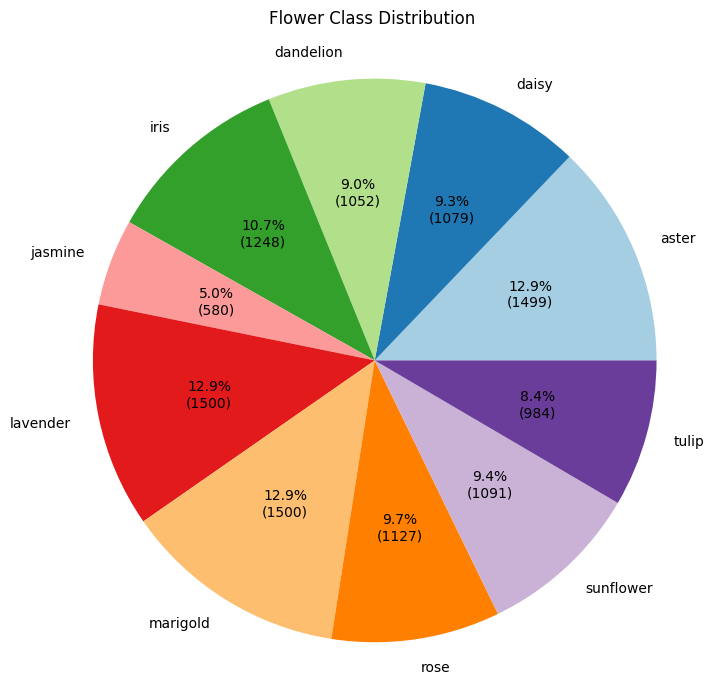

In [ ]:
data_path = 'flowers_data'

class_counts = {cls: len(os.listdir(os.path.join(data_path, cls))) for cls in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, cls))}

class_counts = dict(sorted(class_counts.items(), key=lambda x: x[0]))

def custom_autopct(pct):
    total = sum(class_counts.values())
    count = int(round(pct * total / 100.0))
    return f'{pct:.1f}%\n({count})'

plt.figure(figsize=(8, 8))
plt.pie(
    class_counts.values(),
    labels=class_counts.keys(),
    autopct=custom_autopct,
    colors=plt.cm.Paired.colors
)
plt.title("Flower Class Distribution \n")
plt.axis("equal")
plt.show()


# **Prepare DataFrame**

In [6]:
data_dir = 'flowers_data'

filepaths = []
labels = []

for label in os.listdir(data_dir):
    class_dir = os.path.join(data_dir, label)
    if os.path.isdir(class_dir):
        for fname in os.listdir(class_dir):
            if fname.lower().endswith(('.jpg', '.png', '.jpeg')):
                filepaths.append(os.path.join(class_dir, fname))
                labels.append(label)

df = pd.DataFrame({
    'image_path': filepaths,
    'labels': labels
})

df = df.sample(frac=1, random_state=42).reset_index(drop=True)
df.head()


,image_path,labels
0,flowers_data/sunflower/821368661_4ab4343f5a.jpg,sunflower
1,flowers_data/iris/Iris-Train (1206).jpeg,iris
2,flowers_data/lavender/Lavender-Train (1917).jpeg,lavender
3,flowers_data/lavender/Lavender-Train (1012).jpeg,lavender
4,flowers_data/rose/9320934277_4fb95aef5d_n.jpg,rose


# **Split Dataset**

In [7]:
train_df, temp_df = train_test_split(df, train_size=0.8, stratify=df['labels'], random_state=42)
valid_df, test_df = train_test_split(temp_df, train_size=0.5, stratify=temp_df['labels'], random_state=42)

print("Train:", len(train_df), "Validation:", len(valid_df), "Test:", len(test_df))

Train: 9327 Validation: 1166 Test: 1166


# **Create Image Generators**

In [8]:
batch_size = 16
img_size = (224, 224)

tr_gen = ImageDataGenerator(rescale=1. / 255)
ts_gen = ImageDataGenerator(rescale=1. / 255)

train_gen = tr_gen.flow_from_dataframe(
    train_df,
    x_col='image_path',
    y_col='labels',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size
)

valid_gen = ts_gen.flow_from_dataframe(
    valid_df,
    x_col='image_path',
    y_col='labels',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False,
    batch_size=batch_size
)

test_gen = ts_gen.flow_from_dataframe(
    test_df,
    x_col='image_path',
    y_col='labels',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False,
    batch_size=batch_size
)


Found 9327 validated image filenames belonging to 10 classes.
Found 1166 validated image filenames belonging to 10 classes.
Found 1166 validated image filenames belonging to 10 classes.


In [11]:
class_names = sorted(train_df['labels'].unique())
print("Class Names:", class_names)
print("Number of Classes:", len(class_names))

Class Names: ['aster', 'daisy', 'dandelion', 'iris', 'jasmine', 'lavender', 'marigold', 'rose', 'sunflower', 'tulip']
Number of Classes: 10


# **Display sample from train data**

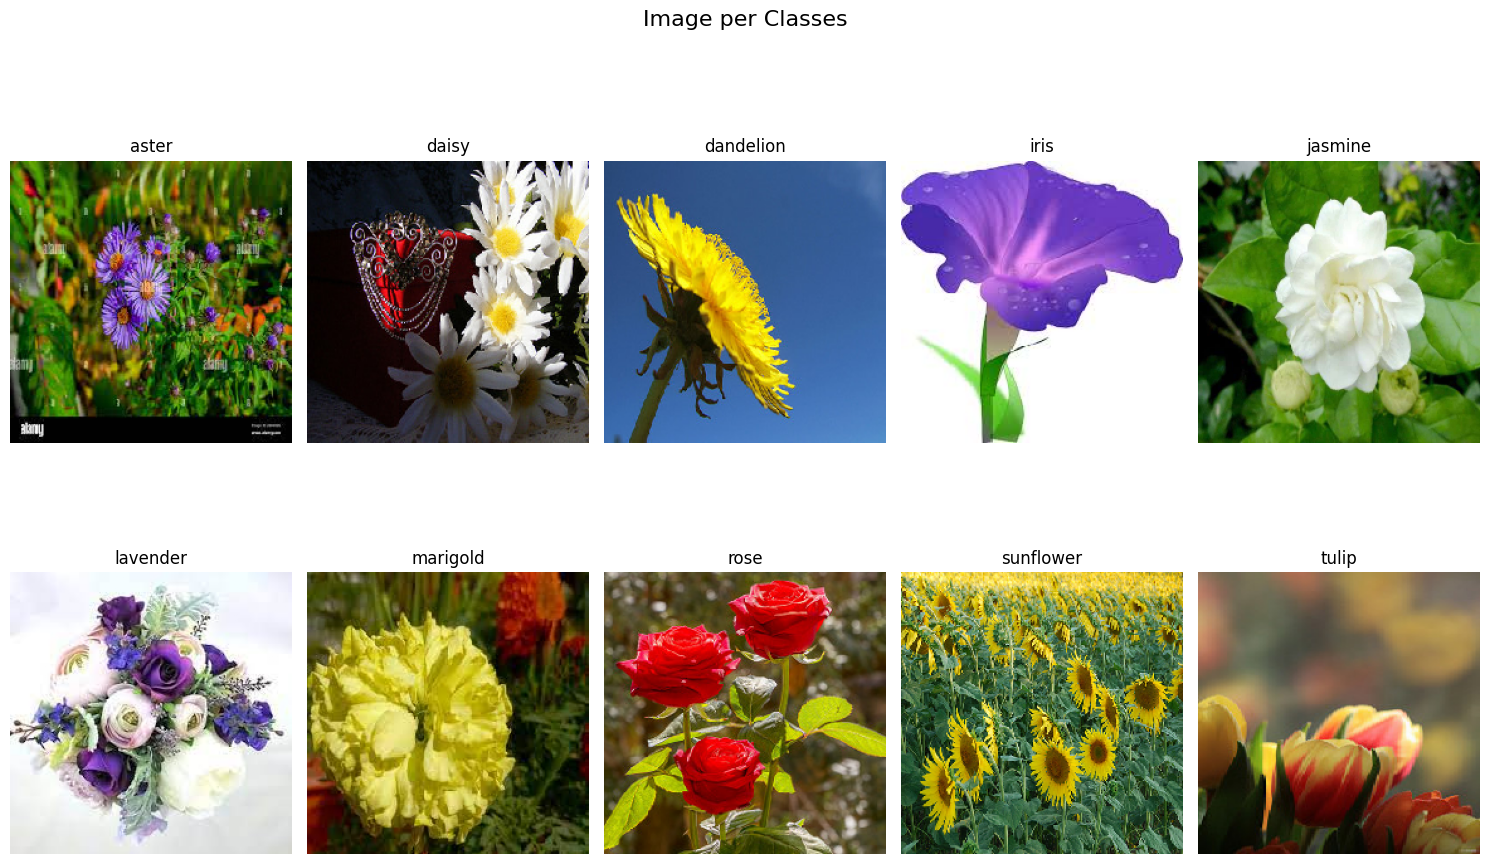

In [10]:
sample_df = train_df.groupby('labels').sample(1, random_state=None).reset_index(drop=True)

plt.figure(figsize=(15, 10))

for i, row in enumerate(sample_df.itertuples()):
    img = load_img(row.image_path, target_size=img_size)
    img_array = img_to_array(img) / 255.0

    plt.subplot(2, 5, i + 1)
    plt.imshow(img_array)
    plt.title(row.labels)
    plt.axis('off')

plt.suptitle("Image per Classes", fontsize=16)
plt.tight_layout()
plt.show()


# **Building the Model (VGG16)**

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Load base model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False

# Get number of classes from generator
num_classes = len(train_gen.class_indices)

# Add custom layers
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Define and compile model
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


# **Model Training**

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint('best_flower_model.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
early_stop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
callbacks = [checkpoint, early_stop]


In [ ]:
history = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=10,
    callbacks=callbacks
)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


583/583 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.3857 - loss: 1.8016

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(



Epoch 1: val_accuracy improved from -inf to 0.68182, saving model to best_flower_model.h5


583/583 ━━━━━━━━━━━━━━━━━━━━ 93s 141ms/step - accuracy: 0.3859 - loss: 1.8011 - val_accuracy: 0.6818 - val_loss: 1.0119
Epoch 2/10
583/583 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.6829 - loss: 1.0053
Epoch 2: val_accuracy improved from 0.68182 to 0.72127, saving model to best_flower_model.h5


583/583 ━━━━━━━━━━━━━━━━━━━━ 67s 115ms/step - accuracy: 0.6829 - loss: 1.0052 - val_accuracy: 0.7213 - val_loss: 0.8715
Epoch 3/10
583/583 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.7579 - loss: 0.7802
Epoch 3: val_accuracy improved from 0.72127 to 0.75214, saving model to best_flower_model.h5


583/583 ━━━━━━━━━━━━━━━━━━━━ 67s 115ms/step - accuracy: 0.7579 - loss: 0.7801 - val_accuracy: 0.7521 - val_loss: 0.7595
Epoch 4/10
583/583 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.7944 - loss: 0.6425
Epoch 4: val_accuracy improved from 0.75214 to 0.76758, saving model to best_flower_model.h5


583/583 ━━━━━━━━━━━━━━━━━━━━ 67s 115ms/step - accuracy: 0.7944 - loss: 0.6425 - val_accuracy: 0.7676 - val_loss: 0.7135
Epoch 5/10
583/583 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.8410 - loss: 0.5202
Epoch 5: val_accuracy improved from 0.76758 to 0.76844, saving model to best_flower_model.h5


583/583 ━━━━━━━━━━━━━━━━━━━━ 67s 115ms/step - accuracy: 0.8410 - loss: 0.5202 - val_accuracy: 0.7684 - val_loss: 0.7190
Epoch 6/10
583/583 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.8617 - loss: 0.4562
Epoch 6: val_accuracy improved from 0.76844 to 0.77101, saving model to best_flower_model.h5


583/583 ━━━━━━━━━━━━━━━━━━━━ 67s 114ms/step - accuracy: 0.8617 - loss: 0.4562 - val_accuracy: 0.7710 - val_loss: 0.6953
Epoch 7/10
583/583 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.8828 - loss: 0.3989
Epoch 7: val_accuracy improved from 0.77101 to 0.78130, saving model to best_flower_model.h5


583/583 ━━━━━━━━━━━━━━━━━━━━ 82s 115ms/step - accuracy: 0.8828 - loss: 0.3989 - val_accuracy: 0.7813 - val_loss: 0.6611
Epoch 8/10
583/583 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.9097 - loss: 0.3161
Epoch 8: val_accuracy improved from 0.78130 to 0.78388, saving model to best_flower_model.h5


583/583 ━━━━━━━━━━━━━━━━━━━━ 82s 115ms/step - accuracy: 0.9097 - loss: 0.3161 - val_accuracy: 0.7839 - val_loss: 0.6615
Epoch 9/10
583/583 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.9205 - loss: 0.2730
Epoch 9: val_accuracy did not improve from 0.78388
583/583 ━━━━━━━━━━━━━━━━━━━━ 66s 114ms/step - accuracy: 0.9205 - loss: 0.2731 - val_accuracy: 0.7684 - val_loss: 0.7029
Epoch 10/10
583/583 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.9280 - loss: 0.2443
Epoch 10: val_accuracy improved from 0.78388 to 0.78473, saving model to best_flower_model.h5


583/583 ━━━━━━━━━━━━━━━━━━━━ 67s 115ms/step - accuracy: 0.9280 - loss: 0.2443 - val_accuracy: 0.7847 - val_loss: 0.6774


# **Accuracy and Loss Graph**

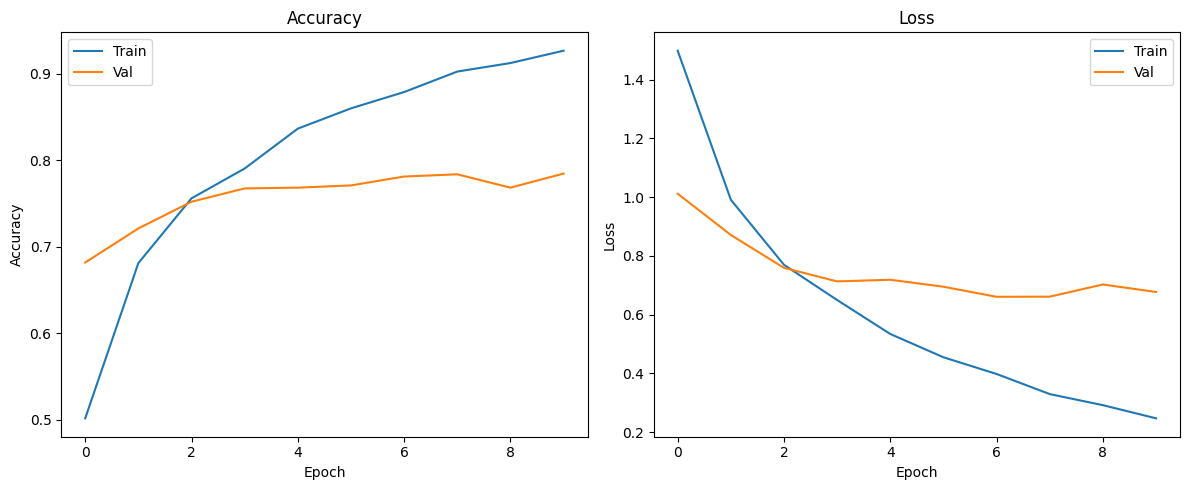

In [ ]:
def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Val')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Val')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)


In [ ]:
def evaluate_model(model, train_gen, valid_gen, test_gen):
    print("🔍 Evaluating Model...")
    train_loss, train_acc = model.evaluate(train_gen, verbose=1)
    valid_loss, valid_acc = model.evaluate(valid_gen, verbose=1)
    test_loss, test_acc = model.evaluate(test_gen, verbose=1)

    print("\n📊 Performance Report:")
    print(f"Train     - Loss: {train_loss:.4f} | Accuracy: {train_acc:.4f}")
    print(f"Valid     - Loss: {valid_loss:.4f} | Accuracy: {valid_acc:.4f}")
    print(f"Test      - Loss: {test_loss:.4f}  | Accuracy: {test_acc:.4f}")

evaluate_model(model, train_gen, valid_gen, test_gen)


🔍 Evaluating Model...
583/583 ━━━━━━━━━━━━━━━━━━━━ 60s 102ms/step - accuracy: 0.9858 - loss: 0.1175
73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 101ms/step - accuracy: 0.7792 - loss: 0.6729
73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 99ms/step - accuracy: 0.7753 - loss: 0.7357

📊 Performance Report:
Train     - Loss: 0.1196 | Accuracy: 0.9839
Valid     - Loss: 0.6774 | Accuracy: 0.7847
Test      - Loss: 0.6889  | Accuracy: 0.7813


# **Confusion Matrix**

57/73 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


73/73 ━━━━━━━━━━━━━━━━━━━━ 8s 104ms/step


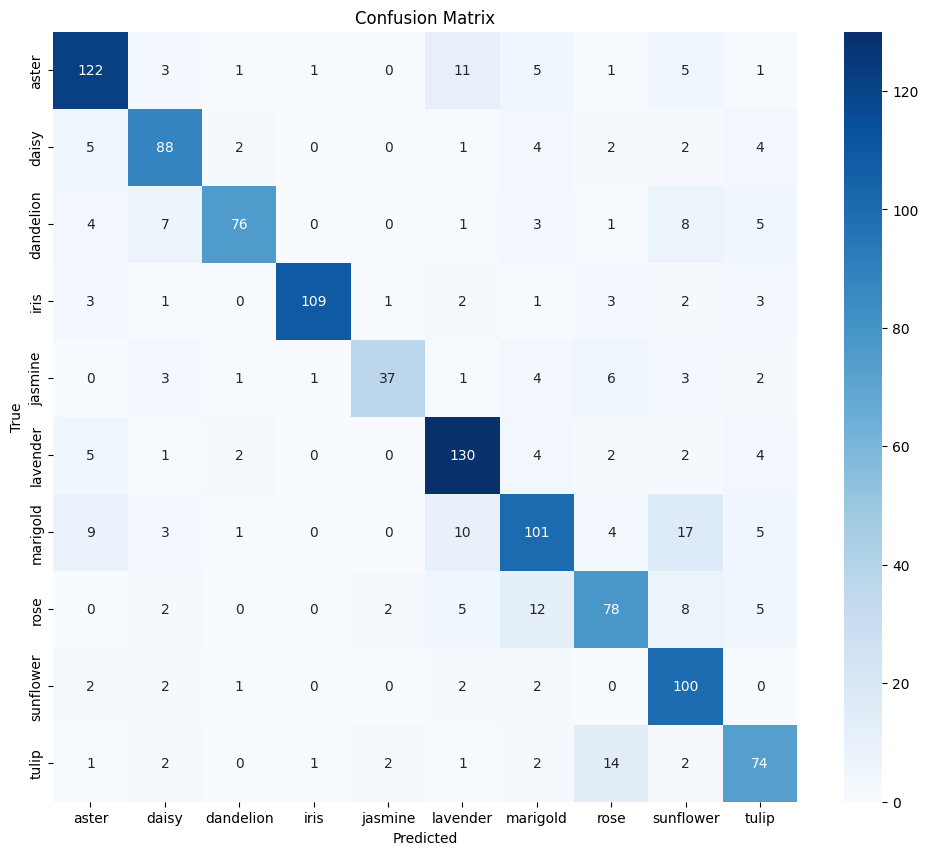

              precision    recall  f1-score   support

       aster       0.81      0.81      0.81       150
       daisy       0.79      0.81      0.80       108
   dandelion       0.90      0.72      0.80       105
        iris       0.97      0.87      0.92       125
     jasmine       0.88      0.64      0.74        58
    lavender       0.79      0.87      0.83       150
    marigold       0.73      0.67      0.70       150
        rose       0.70      0.70      0.70       112
   sunflower       0.67      0.92      0.78       109
       tulip       0.72      0.75      0.73        99

    accuracy                           0.78      1166
   macro avg       0.80      0.78      0.78      1166
weighted avg       0.79      0.78      0.78      1166



In [ ]:
Y_pred = model.predict(valid_gen)
y_pred = np.argmax(Y_pred, axis=1)
y_true = valid_gen.classes

class_labels = list(train_gen.class_indices.keys())

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print(classification_report(y_true, y_pred, target_names=class_labels))


# **Model Accuracy**

In [ ]:
val_loss, val_accuracy = model.evaluate(val_generator)
print(f"Validation Accuracy: {val_accuracy*100:.2f}%")


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


146/146 ━━━━━━━━━━━━━━━━━━━━ 20s 133ms/step - accuracy: 0.9476 - loss: 0.2190
Validation Accuracy: 94.67%


# **Predict and Display Image Label**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Predicted Class: lavender


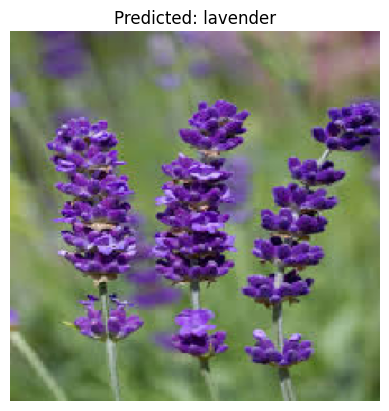

In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

img_path = '/content/lav.jpeg'
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0

predictions = model.predict(img_array)
predicted_class = np.argmax(predictions, axis=1)[0]


class_labels = list(train_generator.class_indices.keys())
predicted_label = class_labels[predicted_class]

print(f"Predicted Class: {predicted_label}")

plt.imshow(img)
plt.title(f"Predicted: {predicted_label}")
plt.axis("off")
plt.show()
